In [1]:
import bamboolib as bam #easy to do data manipulation and highly recommend going to https://bamboolib.8080labs.com/ and that will help you follow along
import pandas as pd #data manipulation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

y = pd.read_csv('Reviews.csv')

Rid Of Very Unhelpful Reviews & Narrow It To First 5000 Due To Data Size

In [2]:
#### Focus on reviews with meaningful feedback (removing very negative ones initially)

train_set = y.loc[(y['Score'] > 2) & (y['Id'] < 15000)]

Bring in packages to get rid of Stopwords. This helps get rid of junk words that aren't meaningful

In [3]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

nltk.download('punkt_eng')
nltk.download('averaged_perceptron_tagger_eng')

import string
from nltk import word_tokenize, pos_tag

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sajalgangrade/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sajalgangrade/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Error loading punkt_eng: Package 'punkt_eng' not found in
[nltk_data]     index
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sajalgangrade/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Loop to strip out nouns

In [4]:
#### Removing nouns from the text.


def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

Now use the loop to strip out nouns from the Text column

In [5]:
data_nouns = pd.DataFrame(train_set.Text.apply(nouns))

Add Stop Words to remove words that aren't useful to analysis but common

In [6]:
from sklearn.feature_extraction import text

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said','br']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)


Turn Data Set Into A Matrix To Look Into Reviews (you will see in the last line we are only looking at the Text field)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words=list(stop_words))
data_cv = cv.fit_transform(data_nouns.Text)
data_dtmn = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_dtmn.index = data_nouns.index


In [8]:
from gensim import matutils
import scipy

# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cv.vocabulary_.items())

Get ready to build model

In [9]:
from gensim import matutils, models
import scipy.sparse


In [10]:
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.017*"treats" + 0.017*"dog" + 0.016*"food" + 0.012*"product" + 0.011*"dogs" + 0.009*"treat" + 0.008*"taste" + 0.008*"crackers" + 0.007*"amazon" + 0.007*"flavor"'),
 (1,
  '0.053*"coffee" + 0.020*"tea" + 0.019*"flavor" + 0.018*"cup" + 0.016*"taste" + 0.015*"product" + 0.011*"amazon" + 0.010*"cups" + 0.009*"price" + 0.008*"water"')]

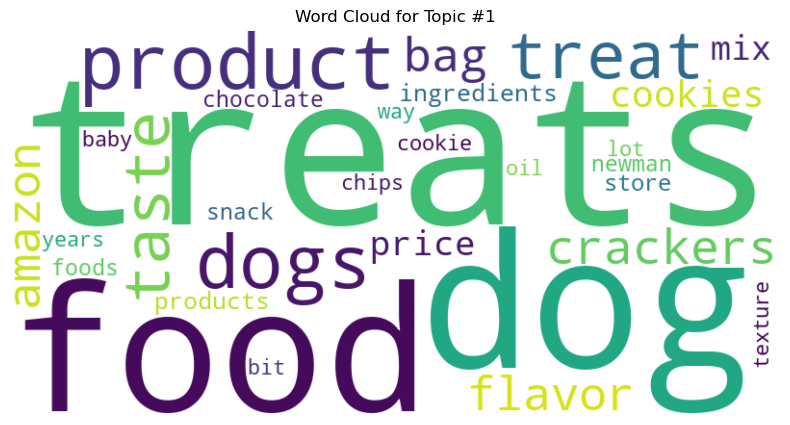

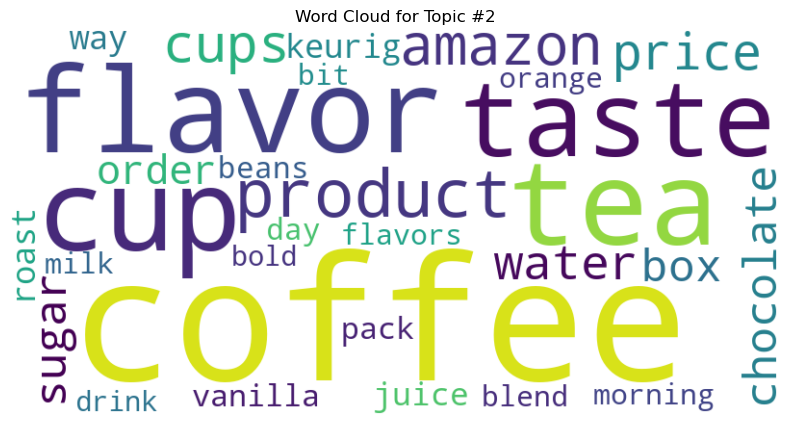

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create word cloud for a topic
def plot_wordcloud(lda_model, topic_num):
    # Get the words and their weights for the topic
    topic = lda_model.show_topic(topic_num, topn=30)  # topn controls how many words
    topic_words = {word: weight for word, weight in topic}

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(topic_words)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic #{topic_num + 1}")
    plt.show()

# Plot for each topic
for topic_num in range(ldan.num_topics):
    plot_wordcloud(ldan, topic_num)

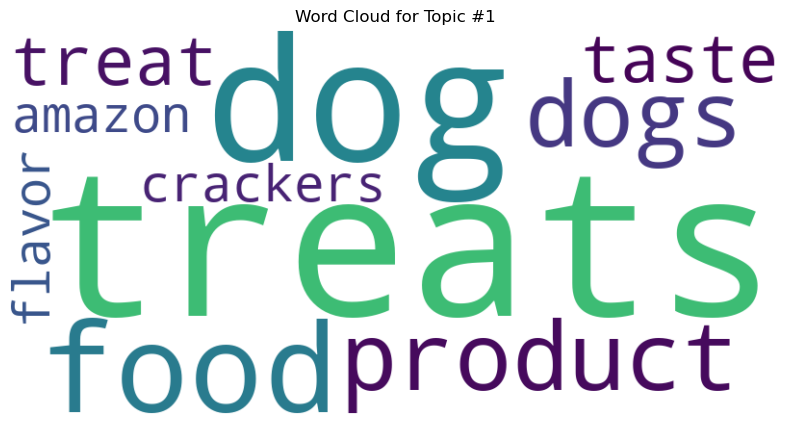

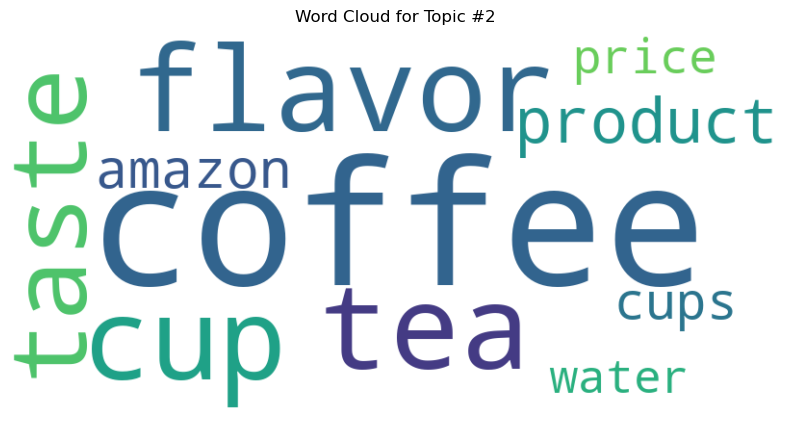

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create word cloud for a topic
def plot_wordcloud(lda_model, topic_num):
    # Get the words and their weights for the topic
    topic = lda_model.show_topic(topic_num, topn=10)  # topn controls how many words
    topic_words = {word: weight for word, weight in topic}

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(topic_words)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic #{topic_num + 1}")
    plt.show()

# Plot for each topic
for topic_num in range(ldan.num_topics):
    plot_wordcloud(ldan, topic_num)

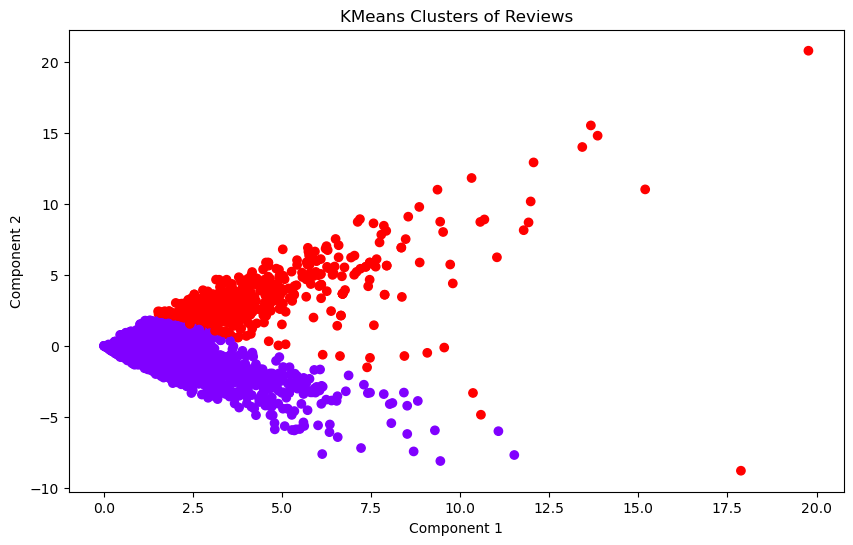

In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# Dimensionality reduction using SVD (like PCA)
svd = TruncatedSVD(n_components=2)

X = cv.fit_transform(train_set['Text'])
X_reduced = svd.fit_transform(X)

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='rainbow')
plt.title('KMeans Clusters of Reviews')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

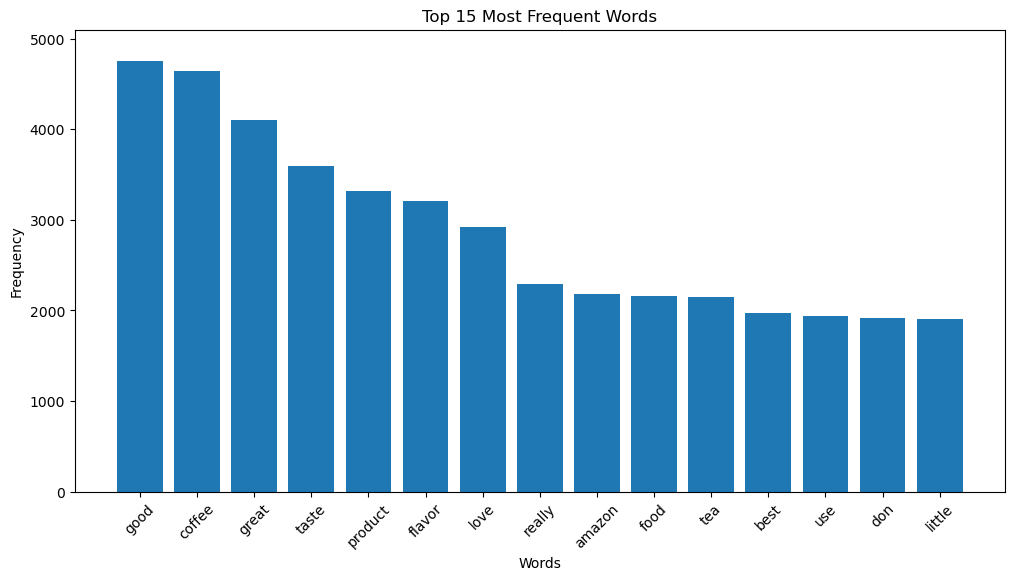

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Vectorizing the reviews (document-term matrix)
vectorizer = CountVectorizer(stop_words=list(stop_words))
X = vectorizer.fit_transform(train_set['Text'])

# Summing up word frequencies
word_counts = X.toarray().sum(axis=0)

# Creating a DataFrame
words_df = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Count': word_counts})
words_df = words_df.sort_values(by='Count', ascending=False).head(15)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(words_df['Word'], words_df['Count'])
plt.xticks(rotation=45)
plt.title('Top 15 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.ylim(0, 5100)
plt.show()